The MIT License (MIT)

Copyright (c) 2020 Weizmann Institute of Science
Copyright (c) 2020 Elad Noor

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from draw_pathways import read_result_sbtab, COFACTORS, COBRA_MODEL
from PyPDF3.merger import PdfFileMerger
from solution import Solution
from tempfile import NamedTemporaryFile

sns.set_style("white")
sns.set_theme("talk")

Academic license - for non-commercial use only - expires 2021-07-04
Using license file /home/eladn/gurobi.lic


In [2]:
stats_df, reaction_df = read_result_sbtab()
stats_df.to_csv("pathway_stats.csv")
reaction_df.pivot(["n_atp", "pathway"], "reaction").reset_index().fillna(
    0.0
).to_csv("pathway_summary.csv")

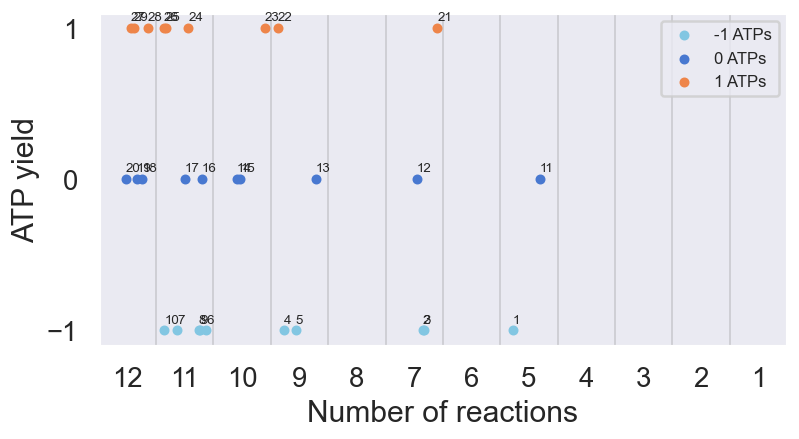

In [3]:
tmp_df = stats_df.reset_index()
tmp_df["index"] += 1
tmp_df["y"] = tmp_df.n_atp
tmp_df["x"] = tmp_df.n_reactions.apply(int) + 0.8 * (np.random.rand(stats_df.shape[0]) - 0.5)

colors = sns.color_palette(palette="muted", n_colors=10)
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=120)

for i, (n_atp, group_df) in enumerate(tmp_df.groupby("n_atp")):
    group_df.plot.scatter(x="x", y="y", color=colors[n_atp], label=f"{n_atp} ATPs", marker="o", zorder=2, ax=ax)
    for row in group_df.itertuples():
        ax.text(row.x, n_atp+0.05, f"{row.index}", fontsize=8)
    
maxx = int(ax.get_xlim()[1])
ax.set_xticks(range(0, maxx+1))
ax.set_xlim(maxx+0.5, 0.5)

for i in range(1, maxx):
    ax.axvline(x=i+0.5, ls="-", linewidth=1, color="grey", alpha=0.3, zorder=0)
ax.xaxis.grid(False)
ax.yaxis.grid(False)

ax.set_xlabel("Number of reactions")
ax.set_ylabel("ATP yield")
ax.set_yticks([-1, 0, 1])
ax.legend(fontsize=10, loc="upper right")
fig.tight_layout()
fig.savefig(f"figureS1.pdf", format="pdf")

In [4]:
pdf_merger = PdfFileMerger()
for i, (gr, group_df) in enumerate(reaction_df.groupby(["n_atp", "pathway"])):
    group_df["!QuantityType"] = "flux"
    group_df["lp_type"] = "variable"
    group_df["name"] = "R@flux@" + group_df.reaction
    group_df["!Value"] = group_df.flux.apply(float)
    sol = Solution(i, COBRA_MODEL, COFACTORS, group_df)
    g_dot, r_nodes, m_nodes = sol.to_graph()
    with NamedTemporaryFile("w+b") as temp_pdf:
        g_dot.write_pdf(temp_pdf.name)
        pdf_merger.append(temp_pdf)

pdf_merger.write("./figureS2.pdf")